In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Reshape,Dense,Input, Activation, BatchNormalization, Lambda, Conv2D, Conv2DTranspose,MaxPooling2D, concatenate,UpSampling2D,Dropout,Add,Flatten
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pydantic import BaseModel
from typing import Optional

In [2]:
class config:
    img_type = 0
    img_color_mode = 'grayscale'
    img_size = [128,128]
    img_channels = 1
    seed = 42
    latent_dim = 100
    train_epochs = 30
    batch_size = 16 
    lr = 1e-4

In [3]:
dir_1 = '../input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png'
dir_2 = '../input/chest-xray-masks-and-labels/Lung Segmentation/test'
df = pd.DataFrame(columns=['img_path'])
for f in os.listdir(dir_1):
    df = df.append({'img_path':f"{dir_1}/{f}"},ignore_index=True)
for f in os.listdir(dir_2):
    df = df.append({'img_path':f"{dir_2}/{f}"},ignore_index=True)

In [4]:
def img_dataset(df_inp,train_path,batch):
    img_gen=ImageDataGenerator(rescale=1./255.)
    data = img_gen.flow_from_dataframe(dataframe=df_inp,
                                     x_col=train_path,
                                     class_mode='input',
                                     batch_size=batch,
                                    color_mode=config.img_color_mode,
                                         seed=1,
                                     target_size=(128,128))
    return data

In [5]:
train=img_dataset(df[:int(0.85*len(df))],'img_path',config.batch_size)
val=img_dataset(df[int(0.85*len(df)):-10],'img_path',config.batch_size)

Found 761 validated image filenames.
Found 125 validated image filenames.


In [6]:
def conv(Inp, num_filters, kernel_size, padding, max_pool, activation):
    conv1 = Conv2D(num_filters, kernel_size, padding=padding)(Inp)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation(activation)(conv1)
    if max_pool:
        conv1 = MaxPooling2D()(conv1)
    return conv1


def convup(Inp, num_filters, kernel_size, padding,
           activation):
    x = Conv2DTranspose(num_filters, kernel_size, padding=padding)(Inp)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = UpSampling2D()(x)
    return x


def sampling(inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


def kl_loss_calc(z_log_var, z_mean):
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    return kl_loss


def rec_loss(y_true, y_rec):
    return K.sqrt(K.mean(K.square(y_true - y_rec)))


class EncInputs(BaseModel):
    num_filters: int
    kernel_size: int = 3
    padding: str = 'same'
    activation: str = 'relu'
    max_pool: bool = True


class DecInputs(BaseModel):
    num_filters: int
    kernel_size: int = 3
    padding: str = 'same'
    activation: str = 'relu'


class Train(tf.keras.Model):

    def __init__(self, encoder, decoder, train, val, train_len, val_len,epochs,lr=1e-3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        self.val_kl = tf.keras.metrics.Mean(name='val_kl_loss')
        self.val_re = tf.keras.metrics.Mean(name='val_re_loss')
        self.val_loss = tf.keras.metrics.Mean(name='val_loss')
        self.train_runner(train,val,train_len,val_len,epochs,lr)

    def call(self,data):
        a,b,c = self.encoder(data)
        d= self.decoder(c)
        return a,b,c,d
    @tf.function
    def train_step(self,data):
        x, y = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z, reconstruction = self(x)
            reconstruction_loss = rec_loss(x, reconstruction)
            kl_loss = kl_loss_calc(z_log_var, z_mean)
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
    @tf.function
    def test_step(self,data):
        x, y = data
        z_mean, z_log_var, z, reconstruction = self(x, training=False)
        reconstruction_loss = rec_loss(x, reconstruction)
        kl_loss = kl_loss_calc(z_log_var, z_mean)
        total_loss = reconstruction_loss + kl_loss
        self.val_kl.update_state(kl_loss)
        self.val_re.update_state(reconstruction_loss)
        self.val_loss.update_state(total_loss)

    def train_runner(self,train,val,train_len,val_len,epochs,lr):
        for t in train:
            break
        self.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
        batch_size = t[0].shape[0]
        for epochs in range(epochs):
            batches = 0
            for data in train:
                self.train_step(data)
                batches += 1
                if batches >= train_len//batch_size:
                    batches = 0
                    break
            for data in val:
                self.test_step(data)
                batches += 1
                if batches > val_len//batch_size:
                    break
            template = (
                "epoch: {}, train_loss: {},val_loss: {}, val_rec: {}, val_kl: {}")
            print(template.format(epochs, self.total_loss_tracker.result(),
                                  self.val_loss.result(), self.val_re.result(),
                                  self.val_kl.result()))


class VAE:
    def __init__(self, input_shape, encoder_arch: list, latent_dims: int,
                 decoder_arch='encoder'):
        self.encoder = None
        self.decoder = None
        self.train_runner = None
        self.encoder_last_conv_shape = None
        self.input_shape = input_shape
        self.encoder_arch = encoder_arch
        self.latent_dims = latent_dims
        self.decoder_arch = decoder_arch
        self.construct_encoder()
        self.construct_decoder()

    def construct_encoder(self):
        Inp = Input(self.input_shape)
        for i, params in enumerate(self.encoder_arch):
            params = EncInputs(**params).dict()
            if i == 0:
                layer = conv(Inp=Inp, **params)
            else:
                layer = conv(Inp=layer, **params)
        self.encoder_last_conv_shape = layer.shape
        layer = Flatten(name='Flatten_encoder_layer')(layer)
        layer = Dense(self.latent_dims, activation='relu')(layer)
        z_mean = Dense(self.latent_dims, name="z_mean")(layer)
        z_log_var = Dense(self.latent_dims, name="z_log_var")(layer)
        z = sampling([z_mean, z_log_var])
        self.encoder = Model(Inp, [z_mean, z_log_var, z], name="encoder")

        return self.encoder

    def construct_decoder(self):
        latent_inputs = tf.keras.Input(shape=(self.latent_dims,))
        shp_ = self.encoder.get_layer('Flatten_encoder_layer').output_shape
        fl = Dense(shp_[1])(latent_inputs)
        re = Reshape(self.encoder_last_conv_shape[1:])(fl)
        if self.decoder_arch == 'encoder':
            self.encoder_arch.reverse()
            self.encoder_arch = self.encoder_arch
        #
        for i, params in enumerate(self.encoder_arch):
            params.pop('max_pool', None)
            params = DecInputs(**params).dict()
            if i == 0:
                layer = convup(Inp=re, **params)
            else:
                layer = convup(Inp=layer, **params)
        out = conv(layer, self.input_shape[2], 1, 'same', False, 'relu')
        self.decoder = Model(latent_inputs, out, name='decoder')

In [7]:
l = [
    {'num_filters': 32, 'kernel_size': 3},
    {'num_filters': 64, 'kernel_size': 3},
    {'num_filters': 128, 'kernel_size': 3}
]
vae = VAE((128, 128, 1), l, 100)

2022-10-30 18:35:57.828479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 18:35:57.899476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 18:35:57.900305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 18:35:57.901760: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
tr = Train(vae.encoder,vae.decoder,train,val,train.samples,val.samples,config.train_epochs)

2022-10-30 18:36:08.987108: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-30 18:36:09.909988: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


epoch: 0, train_loss: 0.3013577461242676,val_loss: 0.23357927799224854, val_rec: 0.23341837525367737, val_kl: 0.0001608729362487793
epoch: 1, train_loss: 0.2602771520614624,val_loss: 0.2176213264465332, val_rec: 0.21753762662410736, val_kl: 8.372969023184851e-05
epoch: 2, train_loss: 0.24605633318424225,val_loss: 0.21205449104309082, val_rec: 0.21199744939804077, val_kl: 5.704168870579451e-05
epoch: 3, train_loss: 0.2388715147972107,val_loss: 0.20842202007770538, val_rec: 0.208378404378891, val_kl: 4.366788562037982e-05
epoch: 4, train_loss: 0.2347376048564911,val_loss: 0.2064073532819748, val_rec: 0.20637166500091553, val_kl: 3.572108835214749e-05
epoch: 5, train_loss: 0.23104526102542877,val_loss: 0.20490117371082306, val_rec: 0.20487074553966522, val_kl: 3.0448061806964688e-05
epoch: 6, train_loss: 0.22824209928512573,val_loss: 0.20406654477119446, val_rec: 0.20403972268104553, val_kl: 2.6851910661207512e-05
epoch: 7, train_loss: 0.22703304886817932,val_loss: 0.2033410668373108, val

In [9]:
gen = tf.random.normal((15,100),0,1)
generated_imgs = vae.decoder(gen)

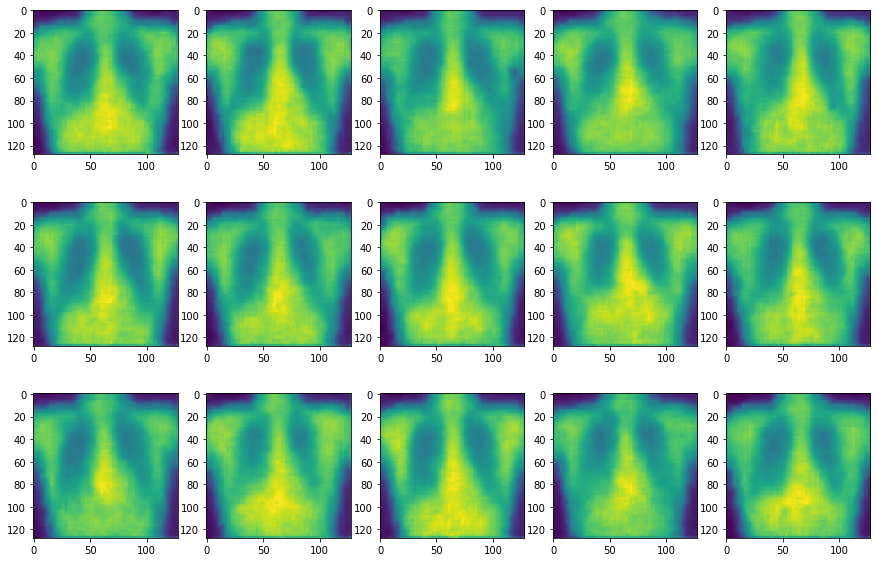

In [10]:
f,ax = plt.subplots(3,5,figsize=(15,10))
ax=ax.flatten()
for i in range(15):
    ax[i].imshow(generated_imgs[i])